In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from scipy.cluster.hierarchy import dendrogram

import re
import string
import time
from PIL import Image
from collections import Counter

import plotly.express as px

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words as nltk_words
from nltk.corpus import stopwords

nltk.download('stopwords', download_dir='../resources')
nltk.download('punkt', download_dir='../resources')
nltk.download('wordnet', download_dir='../resources')
nltk.download('omw-1.4', download_dir='../resources')
nltk.download('words', download_dir='../resources')

[nltk_data] Downloading package stopwords to ../resources...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to ../resources...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to ../resources...
[nltk_data] Downloading package omw-1.4 to ../resources...
[nltk_data] Downloading package words to ../resources...
[nltk_data]   Unzipping corpora/words.zip.


True

In [2]:
nltk.data.path.append('../resources')

# TODO:
* apply models
* compare with google trends **[DONE]**
* change wordcloud colors **[DONE]**
* apply all to descriptions
* run wss for KMeans

## Trends limits:
By default, it is set to 100 requests per 100 seconds per user and can be adjusted to a maximum value of 1,000. But the number of requests to the API is restricted to a maximum of 10 requests per second per user.

In [3]:
!ls && ls ./Data

combined_analysis.ipynb     titles_analysis.ipynb
descriptions_analysis.ipynb
ls: ./Data: No such file or directory


### Configs...

In [4]:
TRENDS = False

# Exploratory Data Analysis

In [5]:
data = pd.read_csv('../data/bbc_news.csv')
data

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,"Mon, 07 Mar 2022 08:01:56 GMT",https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,"Sun, 06 Mar 2022 22:49:58 GMT",https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',"Mon, 07 Mar 2022 00:14:42 GMT",https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,"Mon, 07 Mar 2022 00:05:40 GMT",https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,"Mon, 07 Mar 2022 08:15:53 GMT",https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...
...,...,...,...,...,...
8116,What time is the Queen's funeral? Who will wea...,"Sat, 17 Sep 2022 22:54:46 GMT",https://www.bbc.co.uk/news/uk-62844663,https://www.bbc.co.uk/news/uk-62844663?at_medi...,The death of Queen Elizabeth II has had a majo...
8117,Queen's funeral guests: Who will - and who won...,"Sat, 17 Sep 2022 06:25:17 GMT",https://www.bbc.co.uk/news/uk-62890879,https://www.bbc.co.uk/news/uk-62890879?at_medi...,Here's what we know so far about who will and ...
8118,The cowboy and the Queen who bonded over horses,"Fri, 16 Sep 2022 23:01:06 GMT",https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,Sitting with the heads of state at Monday's fu...
8119,Queen amused by an American's breach of protocol,"Fri, 16 Sep 2022 14:52:59 GMT",https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,When the monarch visited a US housing project ...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8121 entries, 0 to 8120
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        8121 non-null   object
 1   pubDate      8121 non-null   object
 2   guid         8121 non-null   object
 3   link         8121 non-null   object
 4   description  8121 non-null   object
dtypes: object(5)
memory usage: 317.4+ KB


In [7]:
data.describe()

,title,pubDate,guid,link,description
count,8121,8121,8121,8121,8121
unique,7746,7981,7432,7432,7645
top,Ukraine war in maps: Tracking the Russian inva...,"Fri, 15 Jul 2022 15:23:03 GMT",https://www.bbc.co.uk/news/world-europe-60506682,https://www.bbc.co.uk/news/world-europe-605066...,How closely have you been paying attention to ...
freq,32,3,40,40,23


In [8]:
data['pubDate'] = pd.to_datetime(data['pubDate'], infer_datetime_format=True)
data

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...
...,...,...,...,...,...
8116,What time is the Queen's funeral? Who will wea...,2022-09-17 22:54:46,https://www.bbc.co.uk/news/uk-62844663,https://www.bbc.co.uk/news/uk-62844663?at_medi...,The death of Queen Elizabeth II has had a majo...
8117,Queen's funeral guests: Who will - and who won...,2022-09-17 06:25:17,https://www.bbc.co.uk/news/uk-62890879,https://www.bbc.co.uk/news/uk-62890879?at_medi...,Here's what we know so far about who will and ...
8118,The cowboy and the Queen who bonded over horses,2022-09-16 23:01:06,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,Sitting with the heads of state at Monday's fu...
8119,Queen amused by an American's breach of protocol,2022-09-16 14:52:59,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,When the monarch visited a US housing project ...


## Remove duplicates

In [9]:
data = data.drop_duplicates(subset=['title']).drop_duplicates(subset=['guid']).drop_duplicates(subset=['description']).reset_index(drop=True)
data

,title,pubDate,guid,link,description
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as..."
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...
...,...,...,...,...,...
7359,Premiership: Harlequins 27-30 Saracens - Sarri...,2022-09-17 18:07:42,https://www.bbc.co.uk/sport/rugby-union/62927697,https://www.bbc.co.uk/sport/rugby-union/629276...,Saracens battle back from 17-0 down to beat Ha...
7360,The queue - and the expert who helped plan it,2022-09-17 06:35:24,https://www.bbc.co.uk/news/uk-england-cumbria-...,https://www.bbc.co.uk/news/uk-england-cumbria-...,Thousands of people have lined up for miles to...
7361,The cowboy and the Queen who bonded over horses,2022-09-16 23:01:06,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,Sitting with the heads of state at Monday's fu...
7362,Queen amused by an American's breach of protocol,2022-09-16 14:52:59,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,When the monarch visited a US housing project ...


In [10]:
data['title'].str.split(expand=True).stack().value_counts()

to               1807
in               1428
of               1104
and               987
the               893
                 ... 
'confident'         1
impasse             1
'apocalyptic'       1
Wheeler             1
American's          1
Length: 17015, dtype: int64

In [11]:
STOPWORDS = stopwords.words('english')
pd.Series(STOPWORDS)

0             i
1            me
2            my
3        myself
4            we
         ...   
174     weren't
175         won
176       won't
177      wouldn
178    wouldn't
Length: 179, dtype: object

## Remove stopwords and count frequencies for single words

In [12]:
sns.set_style('darkgrid')

In [13]:
top_N = 50
a = data['title'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.cat(sep=' ')
words = list(filter(lambda w: w not in STOPWORDS, nltk.tokenize.word_tokenize(a)))
word_dist = nltk.FreqDist(words)
freq_title = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
freq_title

,Word,Frequency
0,ukraine,728
1,war,503
2,england,352
3,2022,336
4,says,333
5,new,274
6,uk,264
7,world,201
8,us,201
9,win,195


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, 'ukraine'),
  Text(1, 0, 'war'),
  Text(2, 0, 'england'),
  Text(3, 0, '2022'),
  Text(4, 0, 'says'),
  Text(5, 0, 'new'),
  Text(6, 0, 'uk'),
  Text(7, 0, 'world'),
  Text(8, 0, 'us'),
  Text(9, 0, 'win'),
  Text(10, 0, 'v'),
  Text(11, 0, 'russian'),
  Text(12, 0, 'first'),
  Text(13, 0, 'papers'),
  Text(14, 0, 'russia'),
  Text(15, 0, 'man'),
  Text(16, 0, 'city'),
  Text(17, 0, 'queen'),
  Text(18, 0, 'league'),
  Text(19, 0, 'covid'),
  Text(20, 0, 'open'),
  Text(21, 0, 'day'),
  Text(22, 0, 'final'),
  Text(23, 0, 'cup'),
  Text(24, 0, 'euro'),
  Text(25, 0, 'games'),
  Text(26, 0, 'energy'),
  Text(27, 0, 'could'),
  Text(28, 0, 'commonwealth'),
  Text(29, 0, 'pm'),
  Text(30, 0, 'election'),
  Text(31, 0, 'years'),
  Text(32, 0, 'liverpool')

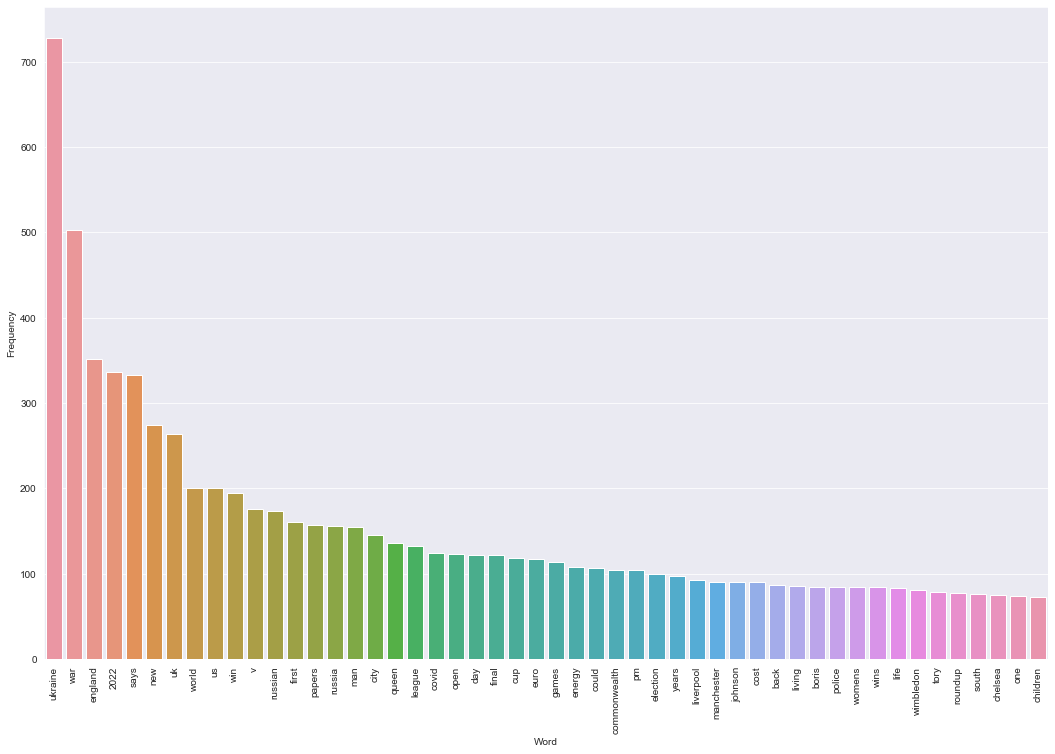

In [14]:
plt.figure(figsize=(18, 12))
sns.barplot(data=freq_title, x='Word', y='Frequency')
plt.xticks(rotation=90)

## Looking for the most popular 2-grams and 3-grams

In [15]:
def find_ngrams(input_list, n):
    return list(zip(*(input_list[i:] for i in range(n))))

In [16]:
bigrams = find_ngrams(words, 2)
bigrams

[('ukraine', 'angry'),
 ('angry', 'zelensky'),
 ('zelensky', 'vows'),
 ('vows', 'punish'),
 ('punish', 'russian'),
 ('russian', 'atrocities'),
 ('atrocities', 'war'),
 ('war', 'ukraine'),
 ('ukraine', 'taking'),
 ('taking', 'cover'),
 ('cover', 'town'),
 ('town', 'attack'),
 ('attack', 'ukraine'),
 ('ukraine', 'war'),
 ('war', 'catastrophic'),
 ('catastrophic', 'global'),
 ('global', 'food'),
 ('food', 'manchester'),
 ('manchester', 'arena'),
 ('arena', 'bombing'),
 ('bombing', 'saffie'),
 ('saffie', 'roussoss'),
 ('roussoss', 'parents'),
 ('parents', 'hearing'),
 ('hearing', 'truth'),
 ('truth', 'ukraine'),
 ('ukraine', 'conflict'),
 ('conflict', 'oil'),
 ('oil', 'price'),
 ('price', 'soars'),
 ('soars', 'highest'),
 ('highest', 'level'),
 ('level', 'since'),
 ('since', '2008'),
 ('2008', 'ukraine'),
 ('ukraine', 'war'),
 ('war', 'pm'),
 ('pm', 'hold'),
 ('hold', 'talks'),
 ('talks', 'world'),
 ('world', 'leaders'),
 ('leaders', 'sanctions'),
 ('sanctions', 'ukraine'),
 ('ukraine', 'w

In [17]:
bigrams_dist = nltk.FreqDist(bigrams)
bigram_freq_title = pd.DataFrame(bigrams_dist.most_common(top_N),
                    columns=['N-gram', 'Frequency'])
bigram_freq_title

,N-gram,Frequency
0,"(ukraine, war)",340
1,"(euro, 2022)",112
2,"(england, v)",96
3,"(commonwealth, games)",92
4,"(world, cup)",73
5,"(boris, johnson)",67
6,"(cost, living)",67
7,"(war, ukraine)",65
8,"(south, africa)",57
9,"(ukraine, roundup)",56


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, "('ukraine', 'war')"),
  Text(1, 0, "('euro', '2022')"),
  Text(2, 0, "('england', 'v')"),
  Text(3, 0, "('commonwealth', 'games')"),
  Text(4, 0, "('world', 'cup')"),
  Text(5, 0, "('boris', 'johnson')"),
  Text(6, 0, "('cost', 'living')"),
  Text(7, 0, "('war', 'ukraine')"),
  Text(8, 0, "('south', 'africa')"),
  Text(9, 0, "('ukraine', 'roundup')"),
  Text(10, 0, "('liz', 'truss')"),
  Text(11, 0, "('platinum', 'jubilee')"),
  Text(12, 0, "('new', 'zealand')"),
  Text(13, 0, "('champions', 'league')"),
  Text(14, 0, "('queen', 'elizabeth')"),
  Text(15, 0, "('tory', 'leadership')"),
  Text(16, 0, "('premier', 'league')"),
  Text(17, 0, "('man', 'city')"),
  Text(18, 0, "('v', 'south')"),
  Text(19, 0, "('elizabeth', 'ii')"),
  Text(20, 0, "('us', '

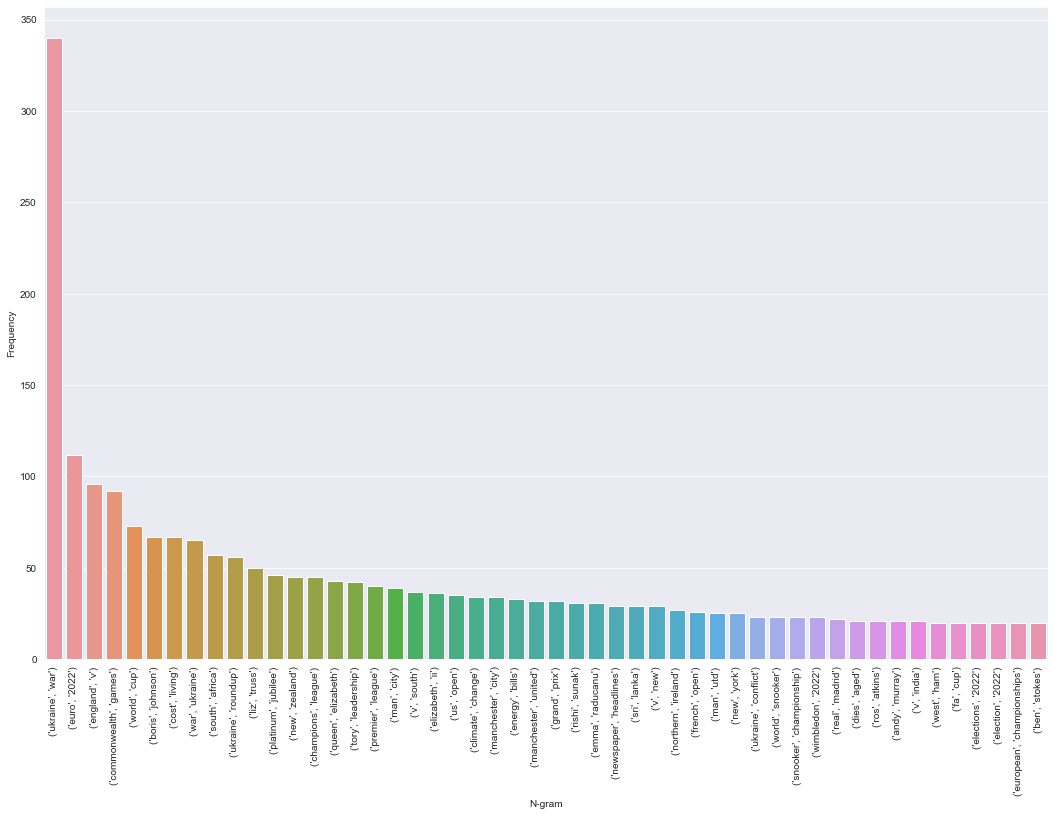

In [18]:
plt.figure(figsize=(18, 12))
sns.barplot(data=bigram_freq_title, x='N-gram', y='Frequency')
plt.xticks(rotation=90)

In [19]:
trigrams = find_ngrams(words, 3)
trigrams

[('ukraine', 'angry', 'zelensky'),
 ('angry', 'zelensky', 'vows'),
 ('zelensky', 'vows', 'punish'),
 ('vows', 'punish', 'russian'),
 ('punish', 'russian', 'atrocities'),
 ('russian', 'atrocities', 'war'),
 ('atrocities', 'war', 'ukraine'),
 ('war', 'ukraine', 'taking'),
 ('ukraine', 'taking', 'cover'),
 ('taking', 'cover', 'town'),
 ('cover', 'town', 'attack'),
 ('town', 'attack', 'ukraine'),
 ('attack', 'ukraine', 'war'),
 ('ukraine', 'war', 'catastrophic'),
 ('war', 'catastrophic', 'global'),
 ('catastrophic', 'global', 'food'),
 ('global', 'food', 'manchester'),
 ('food', 'manchester', 'arena'),
 ('manchester', 'arena', 'bombing'),
 ('arena', 'bombing', 'saffie'),
 ('bombing', 'saffie', 'roussoss'),
 ('saffie', 'roussoss', 'parents'),
 ('roussoss', 'parents', 'hearing'),
 ('parents', 'hearing', 'truth'),
 ('hearing', 'truth', 'ukraine'),
 ('truth', 'ukraine', 'conflict'),
 ('ukraine', 'conflict', 'oil'),
 ('conflict', 'oil', 'price'),
 ('oil', 'price', 'soars'),
 ('price', 'soars', 

In [20]:
trigrams_dist = nltk.FreqDist(trigrams)
trigram_freq_title = pd.DataFrame(trigrams_dist.most_common(top_N),
                    columns=['N-gram', 'Frequency'])
trigram_freq_title

,N-gram,Frequency
0,"(v, south, africa)",37
1,"(england, v, south)",36
2,"(queen, elizabeth, ii)",35
3,"(england, v, new)",29
4,"(v, new, zealand)",29
5,"(world, snooker, championship)",23
6,"(england, v, india)",21
7,"(ukraine, war, russia)",18
8,"(commonwealth, games, 2022)",18
9,"(womens, world, cup)",17


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, "('v', 'south', 'africa')"),
  Text(1, 0, "('england', 'v', 'south')"),
  Text(2, 0, "('queen', 'elizabeth', 'ii')"),
  Text(3, 0, "('england', 'v', 'new')"),
  Text(4, 0, "('v', 'new', 'zealand')"),
  Text(5, 0, "('world', 'snooker', 'championship')"),
  Text(6, 0, "('england', 'v', 'india')"),
  Text(7, 0, "('ukraine', 'war', 'russia')"),
  Text(8, 0, "('commonwealth', 'games', '2022')"),
  Text(9, 0, "('womens', 'world', 'cup')"),
  Text(10, 0, "('roe', 'v', 'wade')"),
  Text(11, 0, "('ukraine', 'war', 'russian')"),
  Text(12, 0, "('euro', '2022', 'england')"),
  Text(13, 0, "('snooker', 'championship', '2022')"),
  Text(14, 0, "('champions', 'league', 'final')"),
  Text(15, 0, "('election', 'results', '2022')"),
  Text(16, 0, "('world', 'cup', '20

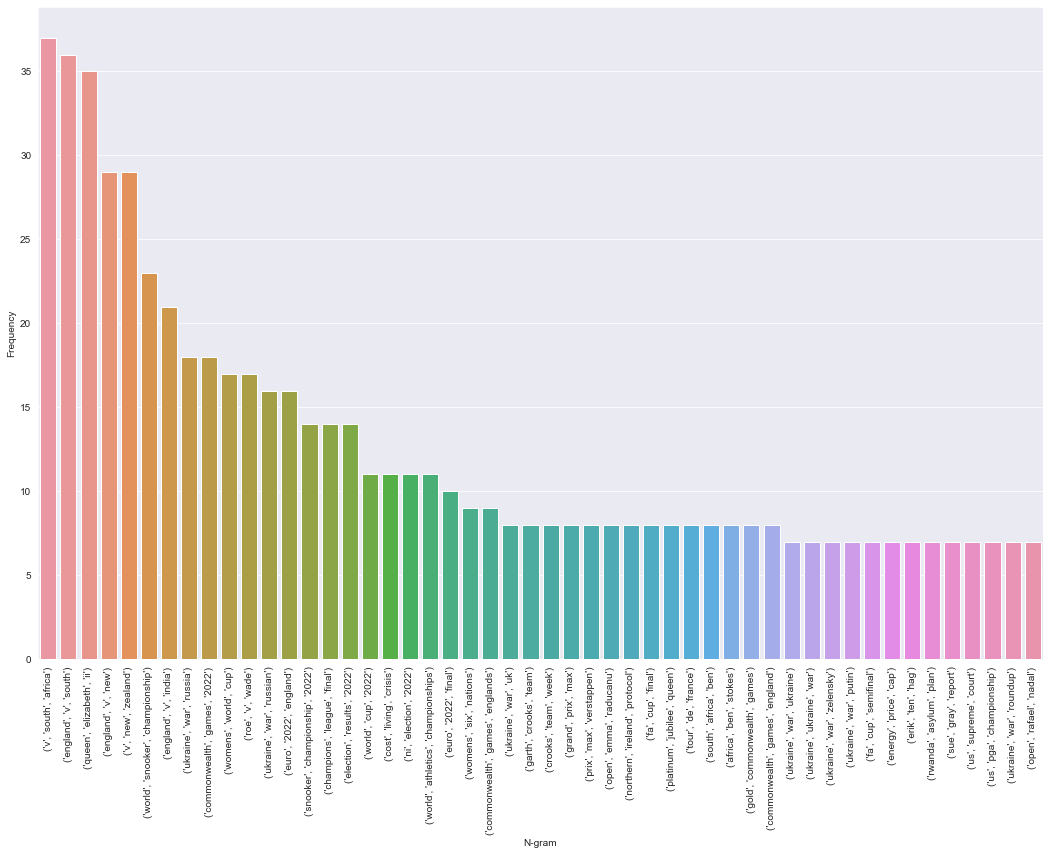

In [21]:
plt.figure(figsize=(18, 12))
sns.barplot(data=trigram_freq_title, x='N-gram', y='Frequency')
plt.xticks(rotation=90)

# Trends analyzing with pytrends

In [22]:
trends = TrendReq(hl='en-US', tz=360, retries=2, backoff_factor=0.1)
trends

In [23]:
timeframe = f'{data["pubDate"].min().strftime("%Y-%m-%d")} {data["pubDate"].max().strftime("%Y-%m-%d")}' # timeframe
timeframe

'2019-10-29 2022-09-18'

In [24]:
top_kws = list(map(lambda x: ' '.join(x[0]), bigrams_dist.most_common(5)))

In [25]:
if TRENDS: # rerun only on demand, since very long running code
    trend_data = pd.DataFrame()
    for kw in top_kws:
        trends.build_payload(kw_list=[kw], timeframe=timeframe)
        trend_data = pd.concat([trend_data, trends.interest_by_region()], axis=1)
        time.sleep(2)
        print(trends.interest_by_region().sort_values(by=[kw], ascending=False))
#     print(trend_data.sort_values(by=top_kws, ascending=False))

In [26]:
if TRENDS:
    for kw in top_kws:
        trend_data.reset_index().plot(x='geoName', y=kw, figsize=(120, 18), kind='bar')

# Top 25 countries to google the keywords

In [27]:
if TRENDS:
    for kw in top_kws:
        trend_data.sort_values(by=[kw], ascending=False)[:25].reset_index().plot(x='geoName', y=kw, figsize=(18, 12), kind='bar')

In [28]:
if TRENDS:
    for kw in top_kws:
        trend_tmp = trend_data.reset_index()
        trend_tmp = trend_tmp[trend_tmp[kw] > 0]

        fig = px.scatter_geo(trend_tmp, locations='geoName', color='geoName',
                             hover_name='geoName', size=kw,
                             projection='natural earth', locationmode='country names', title=kw)
        fig.show()

## Suggestions

In [29]:
suggestions_data = pd.DataFrame()
suggest_terms = pd.Series(dtype=str)
if TRENDS:
    for kw_idx in freq_title['Word'].index[:5]:
        kw = freq_title.loc[kw_idx, 'Word']
        suggests = pd.DataFrame(trends.suggestions(keyword=kw)).drop(columns=['mid'])
        
        suggest_terms = pd.concat([suggest_terms, pd.Series([kw] * len(suggests))])
        
        suggestions_data = pd.concat([suggestions_data, suggests])
        time.sleep(2)
suggestions_data = pd.concat([suggestions_data.reset_index(drop=True), suggest_terms.reset_index(drop=True)], axis=1)
suggestions_data

,0


In [30]:
suggestions_data

,0


## Related queries

In [32]:
if TRENDS: # rerun only on demand, since very long running code
    related_data = pd.DataFrame()
    for kw_idx in bigram_freq_title['N-gram'].index[:5]:
        kw = ' '.join(bigram_freq_title.loc[kw_idx, 'N-gram'])
        
        trends.build_payload(kw_list=[kw], timeframe=timeframe)
        related_queries = trends.related_queries()[kw]['top']
        related_data = pd.concat([related_data, pd.concat([related_queries, pd.Series([kw] * len(related_queries))], axis=1)])
        
        time.sleep(2)

# Cleaning data (removing punctuation)

In [33]:
# lower and remove punctuation
data['title_cleaned'] = data['title'].str.lower() .apply(lambda x: re.sub(f'[{re.escape(string.punctuation)}]', '', x))
data

,title,pubDate,guid,link,description,title_cleaned
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,ukraine angry zelensky vows to punish russian ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",war in ukraine taking cover in a town under at...
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,ukraine war catastrophic for global food
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,manchester arena bombing saffie roussoss paren...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,ukraine conflict oil price soars to highest le...
...,...,...,...,...,...,...
7359,Premiership: Harlequins 27-30 Saracens - Sarri...,2022-09-17 18:07:42,https://www.bbc.co.uk/sport/rugby-union/62927697,https://www.bbc.co.uk/sport/rugby-union/629276...,Saracens battle back from 17-0 down to beat Ha...,premiership harlequins 2730 saracens sarries ...
7360,The queue - and the expert who helped plan it,2022-09-17 06:35:24,https://www.bbc.co.uk/news/uk-england-cumbria-...,https://www.bbc.co.uk/news/uk-england-cumbria-...,Thousands of people have lined up for miles to...,the queue and the expert who helped plan it
7361,The cowboy and the Queen who bonded over horses,2022-09-16 23:01:06,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,Sitting with the heads of state at Monday's fu...,the cowboy and the queen who bonded over horses
7362,Queen amused by an American's breach of protocol,2022-09-16 14:52:59,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,When the monarch visited a US housing project ...,queen amused by an americans breach of protocol


In [34]:
# remove redundant spaces
data['title_cleaned'] = data['title_cleaned'].str.strip()
data

,title,pubDate,guid,link,description,title_cleaned
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,ukraine angry zelensky vows to punish russian ...
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",war in ukraine taking cover in a town under at...
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,ukraine war catastrophic for global food
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,manchester arena bombing saffie roussoss paren...
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,ukraine conflict oil price soars to highest le...
...,...,...,...,...,...,...
7359,Premiership: Harlequins 27-30 Saracens - Sarri...,2022-09-17 18:07:42,https://www.bbc.co.uk/sport/rugby-union/62927697,https://www.bbc.co.uk/sport/rugby-union/629276...,Saracens battle back from 17-0 down to beat Ha...,premiership harlequins 2730 saracens sarries ...
7360,The queue - and the expert who helped plan it,2022-09-17 06:35:24,https://www.bbc.co.uk/news/uk-england-cumbria-...,https://www.bbc.co.uk/news/uk-england-cumbria-...,Thousands of people have lined up for miles to...,the queue and the expert who helped plan it
7361,The cowboy and the Queen who bonded over horses,2022-09-16 23:01:06,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,Sitting with the heads of state at Monday's fu...,the cowboy and the queen who bonded over horses
7362,Queen amused by an American's breach of protocol,2022-09-16 14:52:59,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,When the monarch visited a US housing project ...,queen amused by an americans breach of protocol


In [35]:
data['title_cleaned'][0], data['title_cleaned'][1]

('ukraine angry zelensky vows to punish russian atrocities',
 'war in ukraine taking cover in a town under attack')

In [36]:
data['title_cleaned'].apply(len).describe()

count    7364.000000
mean       59.975014
std        12.980796
min        15.000000
25%        51.000000
50%        58.000000
75%        67.000000
max       139.000000
Name: title_cleaned, dtype: float64

# Lemmatization

In [37]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('civilians')

'civilian'

In [38]:
data['title_cleaned']=data['title_cleaned'].apply(lambda x: ' '.join(map(lemmatizer.lemmatize, filter(lambda w: w not in STOPWORDS, nltk.tokenize.word_tokenize(x)))))
data['title'][100], data['title_cleaned'][100]

('Cost of living: Warning UK faces biggest income squeeze in nearly 50 years',
 'cost living warning uk face biggest income squeeze nearly 50 year')

## Normalizing data

In [39]:
cv = CountVectorizer(analyzer='word')
cv_data = cv.fit_transform(data['title_cleaned'])
dtm_data = pd.DataFrame(cv_data.toarray(), columns=cv.get_feature_names_out())
dtm_data.index = data.index
dtm_data.head(5)

,00,01,02,03,04,10,100,1000,10000,100000,...,zombie,zombified,zone,zoo,zoom,zulu,zurich,zuu,zverev,zwelithini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
dtm_data.iloc[:, 500:]

,agency,agenda,agent,agg,aggregate,aggression,aggressive,aging,ago,agonising,...,zombie,zombified,zone,zoo,zoom,zulu,zurich,zuu,zverev,zwelithini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7359,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7360,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7361,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Wordclouds

In [41]:
# Function for generating word clouds
def generate_wordcloud(data, title, bg='white', colormap='Dark2', mask=None):
    wc = WordCloud(width=1600, height=1080, max_words=150, colormap=colormap, mask=mask, background_color=bg).generate_from_frequencies(data)
    plt.figure(figsize=(16,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('\n'.join(wrap(title,60)),fontsize=26)
    plt.show()

In [45]:
ASSETS_PATH = '../assets'

In [46]:
f100_mask = np.array(Image.open(ASSETS_PATH + '/100.png'))

In [47]:
latest100indexes = data.sort_values(by=['pubDate'], ascending=False).index

## Latest 100 titles

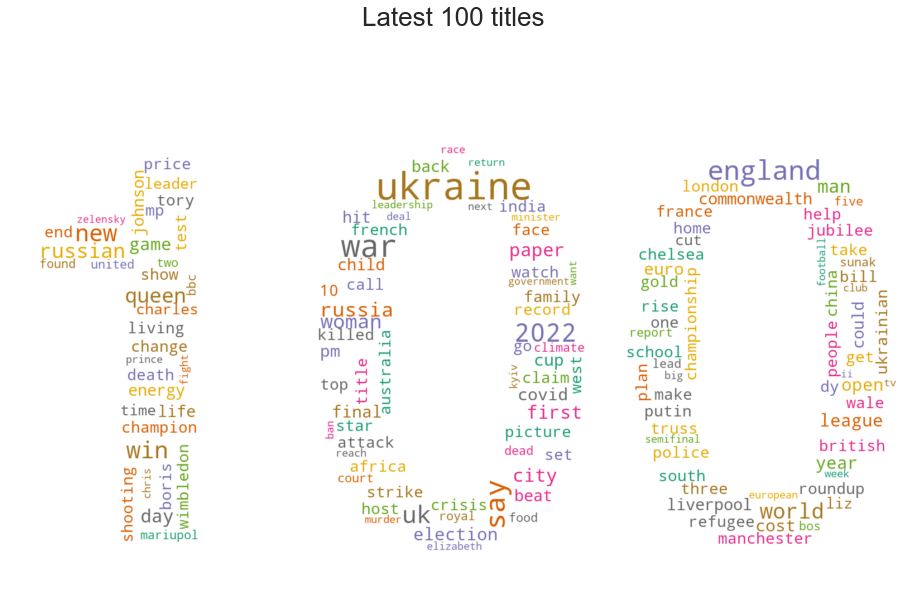

In [48]:
generate_wordcloud(dtm_data.loc[latest100indexes].T.sum(axis=1), 'Latest 100 titles', mask=f100_mask)

## Latest 500 titles

In [49]:
f500_mask = np.array(Image.open(ASSETS_PATH + '/500.png'))

In [50]:
latest500indexes = data.sort_values(by=['pubDate'], ascending=False).index

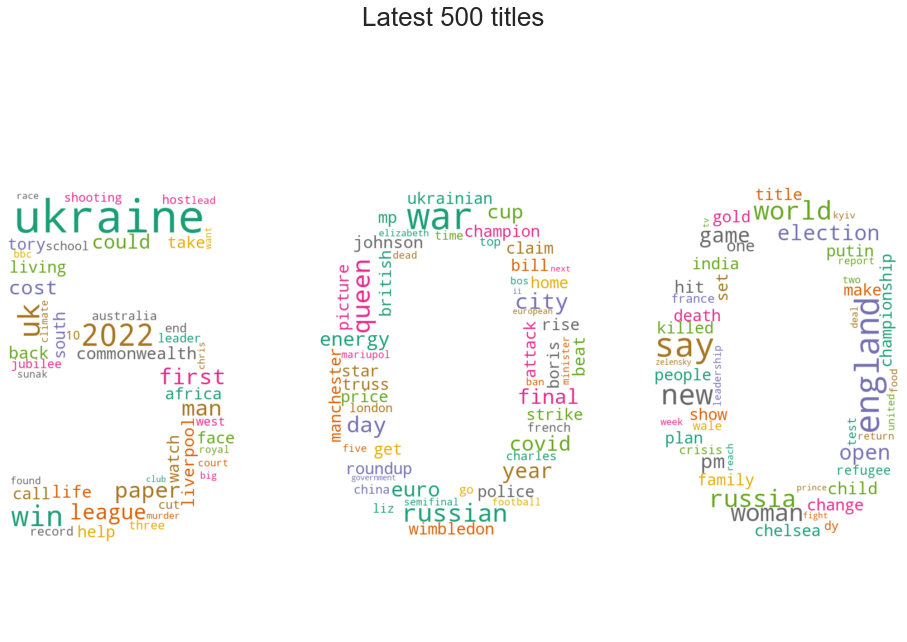

In [51]:
generate_wordcloud(dtm_data.loc[latest500indexes].T.sum(axis=1), 'Latest 500 titles', mask=f500_mask)

In [52]:
data['title_polarity'] = data['title_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
data

,title,pubDate,guid,link,description,title_cleaned,title_polarity
0,Ukraine: Angry Zelensky vows to punish Russian...,2022-03-07 08:01:56,https://www.bbc.co.uk/news/world-europe-60638042,https://www.bbc.co.uk/news/world-europe-606380...,The Ukrainian president says the country will ...,ukraine angry zelensky vow punish russian atro...,-0.250000
1,War in Ukraine: Taking cover in a town under a...,2022-03-06 22:49:58,https://www.bbc.co.uk/news/world-europe-60641873,https://www.bbc.co.uk/news/world-europe-606418...,"Jeremy Bowen was on the frontline in Irpin, as...",war ukraine taking cover town attack,0.000000
2,Ukraine war 'catastrophic for global food',2022-03-07 00:14:42,https://www.bbc.co.uk/news/business-60623941,https://www.bbc.co.uk/news/business-60623941?a...,One of the world's biggest fertiliser firms sa...,ukraine war catastrophic global food,0.000000
3,Manchester Arena bombing: Saffie Roussos's par...,2022-03-07 00:05:40,https://www.bbc.co.uk/news/uk-60579079,https://www.bbc.co.uk/news/uk-60579079?at_medi...,The parents of the Manchester Arena bombing's ...,manchester arena bombing saffie roussoss paren...,0.000000
4,Ukraine conflict: Oil price soars to highest l...,2022-03-07 08:15:53,https://www.bbc.co.uk/news/business-60642786,https://www.bbc.co.uk/news/business-60642786?a...,Consumers are feeling the impact of higher ene...,ukraine conflict oil price soar highest level ...,0.000000
...,...,...,...,...,...,...,...
7359,Premiership: Harlequins 27-30 Saracens - Sarri...,2022-09-17 18:07:42,https://www.bbc.co.uk/sport/rugby-union/62927697,https://www.bbc.co.uk/sport/rugby-union/629276...,Saracens battle back from 17-0 down to beat Ha...,premiership harlequin 2730 saracen sarries win...,0.183333
7360,The queue - and the expert who helped plan it,2022-09-17 06:35:24,https://www.bbc.co.uk/news/uk-england-cumbria-...,https://www.bbc.co.uk/news/uk-england-cumbria-...,Thousands of people have lined up for miles to...,queue expert helped plan,0.000000
7361,The cowboy and the Queen who bonded over horses,2022-09-16 23:01:06,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,Sitting with the heads of state at Monday's fu...,cowboy queen bonded horse,0.000000
7362,Queen amused by an American's breach of protocol,2022-09-16 14:52:59,https://www.bbc.co.uk/news/world-us-canada-629...,https://www.bbc.co.uk/news/world-us-canada-629...,When the monarch visited a US housing project ...,queen amused american breach protocol,0.000000


In [53]:
data.describe()

,title_polarity
count,7364.000000
mean,0.036574
std,0.237512
min,-1.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


## 20 most negative News

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_3935/1809041618.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  title_polarity_sorted = data['title_polarity'].sort_values(ascending=True).copy()[:200:10]


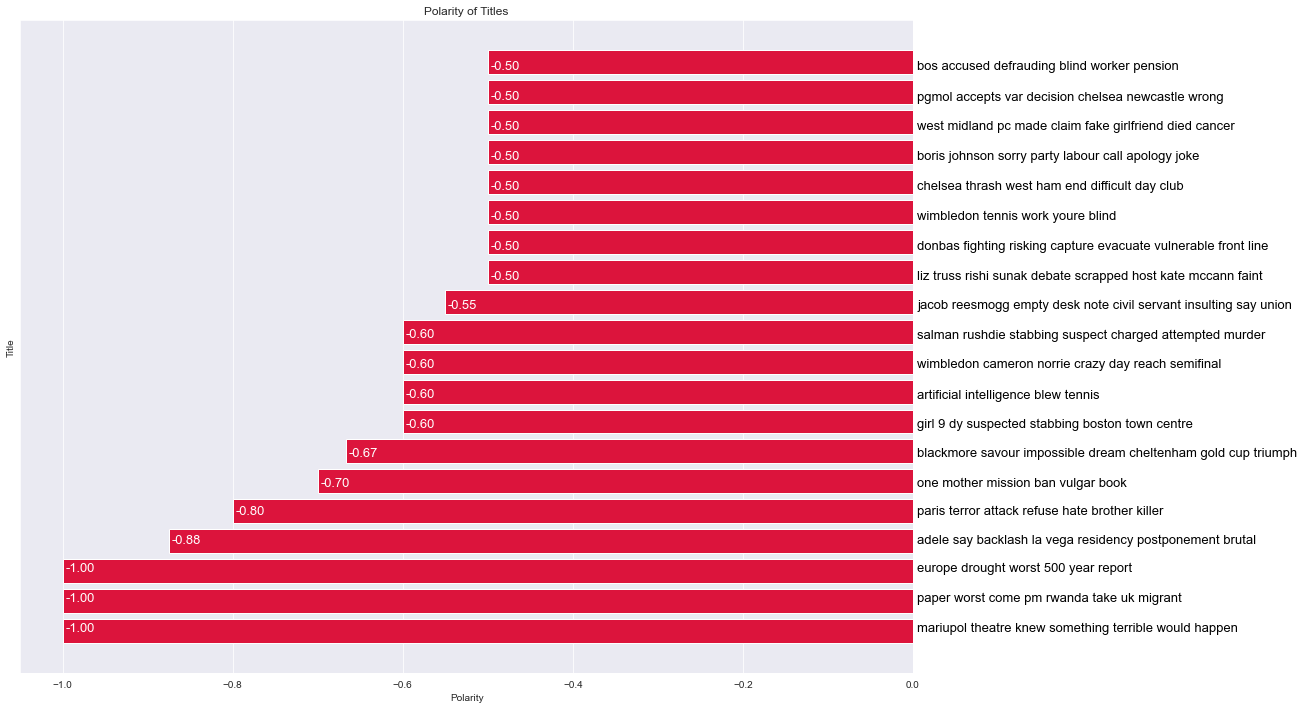

In [54]:
title_polarity_sorted = data['title_polarity'].sort_values(ascending=True).copy()[:200:10]

plt.figure(figsize=(16,12))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Titles')
polarity_graph=plt.barh(np.arange(len(title_polarity_sorted.index)), title_polarity_sorted, color='crimson')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(0.005, bar.get_y() - bar.get_width() / 2, str(data['title_cleaned'][polarity_idx]), va='center', fontsize=13, color='black')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(bar.get_width() + 0.003, bar.get_y() - bar.get_width() / 2,'{:.2f}'.format(title_polarity_sorted[polarity_idx]), va='center', fontsize=13, color='white')

plt.yticks([])
plt.show()

In [55]:
title_polarity_sorted

516    -1.000000
1560   -1.000000
6471   -1.000000
4475   -0.875000
4486   -0.800000
1112   -0.700000
576    -0.666667
5463   -0.600000
3283   -0.600000
4612   -0.600000
6105   -0.600000
1889   -0.550000
5382   -0.500000
2340   -0.500000
4541   -0.500000
245    -0.500000
1727   -0.500000
6031   -0.500000
6878   -0.500000
302    -0.500000
Name: title_polarity, dtype: float64

In [56]:
thumb_down_mask = np.array(Image.open(ASSETS_PATH + '/thumb-up.png').transpose(method=Image.FLIP_TOP_BOTTOM))
thumb_down_mask-=1
thumb_down_mask[thumb_down_mask == 0] = 255

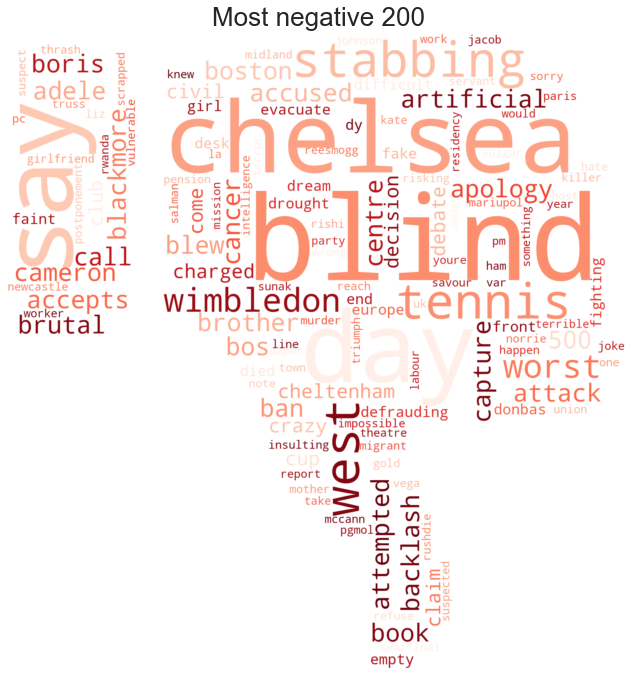

In [57]:
generate_wordcloud(dtm_data.loc[title_polarity_sorted.index].T.sum(axis=1), 'Most negative 200', colormap='Reds', mask=thumb_down_mask)

# 20 most positive news

/var/folders/tn/_r_b9n8d0bg1fzccsh7yq_sc0000gn/T/ipykernel_3935/1553687561.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  title_polarity_sorted = data['title_polarity'].sort_values(ascending=True).copy()[-200::10]


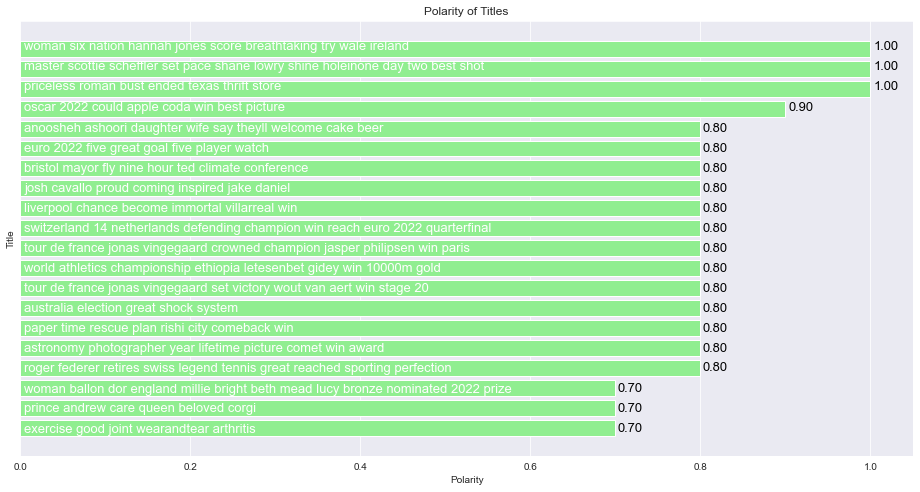

In [58]:
title_polarity_sorted = data['title_polarity'].sort_values(ascending=True).copy()[-200::10]

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Titles')
polarity_graph=plt.barh(np.arange(len(title_polarity_sorted.index)), title_polarity_sorted, color='lightgreen')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(0.005, bar.get_y() + bar.get_width() / 2, str(data['title_cleaned'][polarity_idx]), va='center', fontsize=13, color='white')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(bar.get_width() + 0.003, bar.get_y() + bar.get_width() / 2,'{:.2f}'.format(title_polarity_sorted[polarity_idx]), va='center', fontsize=13, color='black')
    
plt.yticks([])
plt.show()

In [59]:
thumb_up_mask = np.array(Image.open(ASSETS_PATH + '/thumb-up.png'))
thumb_up_mask-=1
thumb_up_mask[thumb_up_mask == 0] = 255

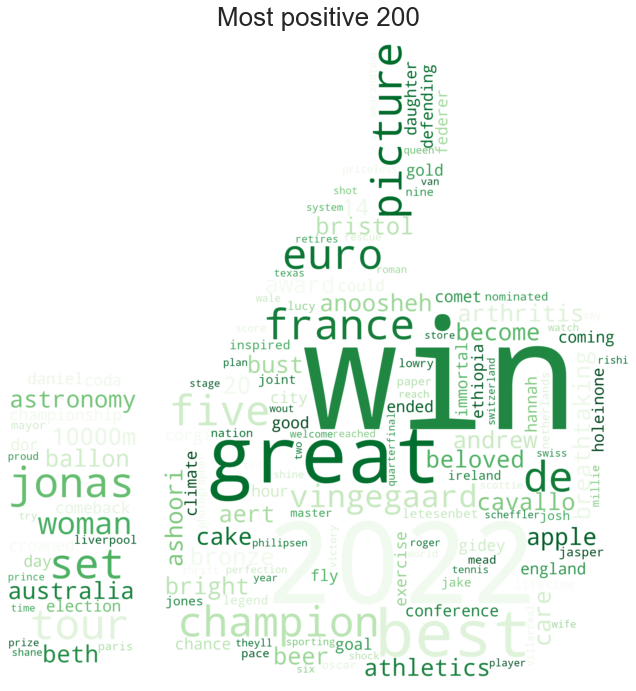

In [60]:
generate_wordcloud(dtm_data.loc[title_polarity_sorted.index].T.sum(axis=1), 'Most positive 200', colormap='Greens', mask=thumb_up_mask)